# Extract particle count from the EPD signal  

I study flow at the STAR experiment at RHIC. The main detector I use in my analysis is the Event Plane Detector (EPD). To measure flow, I need to know the number of particles hitting each EPD tile (averaged over all the events). However, as a scintillator detector, EPD can't distinguish each single particle, it can only measure the energy deposited by those particles in each tile. More importantly, the deposited energy is not proportional to the number of particles hitting the tile. Every time a particle goes through a EPD tile, the deposited energy follows a Landau distrbution whose width depends on the material and thickness of the detector. Then when two particles go through EPD, the deposited energy distribution will be a convolution of this Landau distribution with itself. For three particles, it will be the convolution of this Landau distribution with the two-particle-case distribution and so on. <br><br>
In order to get the particle count, I need to know, from the signal distribution (we call it nMip distribution), the probability of one particle going through EPD, the probability of two particles going through EPD , the probability of three particles..... But when to stop (what is the $N_{max}$)? I don't know, that's one of the things I want to try figuring out with Bayesian analysis! In my research, I usually guess a stop point based on the collision energy, for example, $N_{max}=4$ at 27 GeV and $N_{max}=5$ at 200 GeV. Then I use Minuit for the maximum likelihood estimate. If my guess is wrong, it can mess up the fit. For example, the probability of 4 particles might be zero with a huge error bar (which means I need to switch to $N_{max}=3$). The error bars associated with these model parameters will be passed down to the next step of the analysis and eventually influence the final results. So in this project I will use model selection to see if I can decide the best $N_{max}$ to use.<br><br>
As you will see soon in the data, the nMip distribution can't be perfectly described by the convoluted Landau distribution. That is due to all kinds of backgroud noises. According to the EPD construction proposal(https://arxiv.org/pdf/2002.09830.pdf), in order to characterize the nMip distribution, we need to convolute a Landau distribution for the energy loss, with a Poisson distribution for the probability of measuring the number of photons, a Gaussian distribution to account for the electronic noise and finally an exponential or Gaussian function to account for the pedestal distribution. But in reality, even this is not enough to "perfectly" describe the nMip distribution. It is fine, I can still trust the probabilities extracted from the fit only using Landau distribution. However, the big $\chi^2$ makes me unsure of the error bars associated with the probabilities and error bars matter. <br><br>
With Bayesian analysis, there are two ways to tackle the problem. One is to assume the model is perfect ($\sigma_{th}=0$) and some data points are "outliers" due to huge backgroud noise therefore their error bars should be enlarged. The other way is to assume all the data are good, but our model is not good enough so we should add a theory error $\sigma_{th}$ when calculating $\chi^2$. Both ways share the same underlying idea which is to get both the theory and experiment error under control. In this project, I will try the second method. 

Finally, a teaser, maybe becasue my model is too complicated (a lot of convolution) or maybe because my laptop is too old (MacBook Air 2015), it took forever when I tried the model with $N_{max}=3$ or more (it took ~2 hours for $N_{max}=2$, long but acceptable). Therefore in this project, I only tried $N_{max}=1$ and $N_{max}=2$. In the real analysis, it is obvious that $N_{max}=1$ and $N_{max}=2$ are not good enough. 

## Set up the environment 


In order to run this jupyter notebook, you need to install root through conda (https://iscinumpy.gitlab.io/post/root-conda/). I used:<br> ```conda create -n my_root_env root -c conda-forge```. Then I added -root to the 8820 enviroment script: environment.yml. 

In [1]:
import matplotlib
import matplotlib.pyplot as plt

import numpy as np
import scipy.stats, scipy
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
sns.set() # set default plot styles

#import emcee
#import ptemcee
#import corner

## 1. Data: the nMip distribution 

In [2]:
from io import StringIO

In [3]:
data=np.loadtxt("nMip.out",delimiter=",")

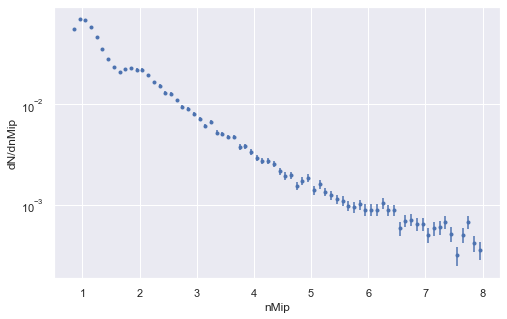

In [4]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.set_yscale('log')
plt.errorbar(data[0][8:],data[1][8:],data[2][8:],fmt='.b')
ax.set_xlabel("nMip")
ax.set_ylabel("dN/dnMip")
plt.show()

## 2. Prior, likelihood and posterior functions

In [2]:
from ROOT import TMath,TF1Convolution,TF1

Welcome to JupyROOT 6.26/04


In [3]:
f1=TF1("f1",'TMath::Landau(x,[0],[1],1)')
fconv_2 = TF1Convolution("f1", "f1",0.0,64,1)
#note the range for convolution is important!
f2 = TF1("f2", fconv_2, 0.0, 32, fconv_2.GetNpar())
fconv_3 = TF1Convolution("f2", "f1",0.0,64,1)
f3 = TF1("f3", fconv_3, 0.0, 32, fconv_3.GetNpar())
fconv_4 = TF1Convolution("f3", "f1",0.0,64,1)
f4 = TF1("f4", fconv_4, 0.0, 32, fconv_4.GetNpar())

myfuncs=[f1,f2,f3,f4]

There are $N_{max}+2$ parameters for the model: MPV and WID/MPV of the Landau distribution, MIPWeight (probability) for each number of particles.

In [4]:
def vec_myfuncs_sum(x,alpha):
    loc=alpha[0]
    wid=alpha[1]
    w=alpha[2:]
    p=len(w)
    y=np.zeros_like(x)
    for m in range(p):
        for j in range(0,2*m+2,2):
            myfuncs[m].SetParameter(j,loc)
            myfuncs[m].SetParameter(j+1,wid)
        for i in range(len(x)):
            y[i]=y[i]+w[m]*myfuncs[m](x[i])
    return y

Here is a demonstration of the model with $N_{max}=3$. The parameters were set to: MPV=0.9855, WID/MPV=0.1543, 1MIPWeight=0.05977, 2MIPWeight=0.0185, 3MIPWeight=0.00031. Blue curve is the nMip distribution when one particle passes EPD, yellow curve is the nMip distribution when two particels pass EPD and the green curve is the nMip distribution when three particles pass EPD. All three curves were weighted by the corresponding probability (nMIPWeight). The red curve is the sum of these three curves. In this case, the average particle count will be $0.05977+0.0185\times2+0.00031\times3=0.4307$.

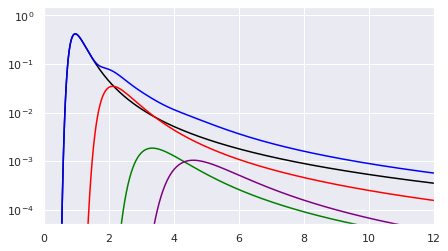

In [13]:
x=np.linspace(0.0,32.0,3200)
fig, ax = plt.subplots(figsize=(7, 4))
ax.set_yscale('log')
ax.set_ylim([0.00005,1.5])
ax.set_xlim([0.0,12.0])
plt.plot(x,vec_myfuncs_sum(x,[1.0,0.13,0.3]),color="black")
plt.plot(x,vec_myfuncs_sum(x,[1.0,0.13,0.0,0.05]),color='red')
plt.plot(x,vec_myfuncs_sum(x,[1.0,0.13,0.0,0.0,0.004]),color="green")
plt.plot(x,vec_myfuncs_sum(x,[1.0,0.13,0.0,0.0,0.0,0.003]),color="purple")
plt.plot(x,vec_myfuncs_sum(x,[1.0,0.13,0.3,0.05,0.004,0.003]),color="blue")
#plt.plot(x,vec_myfuncs_sum(x,[0.9855,0.1543,0.05977,0.0,0.0]))
#plt.plot(x,vec_myfuncs_sum(x,[0.9855,0.1543,0.0,0.0185,0.0]))
#plt.plot(x,vec_myfuncs_sum(x,[0.9855,0.1543,0.0,0.0,0.00031]))
#plt.plot(x,vec_myfuncs_sum(x,[0.9855,0.1543,0.05977,0.0185,0.00031]))
plt.rcParams.update({'font.size': 30})
plt.show()

Use a uniform prior, the range is based on the "perfect" situation where MPV is close to one and WID/MPV=0.16 given the EPD material. 

In [9]:
xmin=0.5
xmax=1.5#MPV
wmax=0.3#WID/MPV
Amax=1.0#MipWeight

In [10]:
def log_prior(alpha):
    '''Logarithm of prior.
    
    Flat priors over predetermined ranges
    Location of the one-mip landau dis. is the first element [0]
    WID/MPV of the one-mip landau dis. is the second element [1]
    Probabilities of i particles hitting EPD is the (i+2) element [i+1] 
  
    '''
    
    # All parameters must be positive
    if np.any(alpha < 0):
        return -np.inf  # log(0)
    # All probabilities are assumed to be smaller than Amax
    elif np.any(alpha[2:] > Amax) :
        return -np.inf
    # The location is assumed to be in the [xmin, xmax] range
    elif np.any(alpha[0] > xmax) or np.any(alpha[0] < xmin):
    #elif np.any(alpha[0] > 2):
        return -np.inf
    # The wid/mpv is assumed to be in the [wmin,wmax] range
    elif np.any(alpha[1] > wmax):
    #elif alpha[1] > 1:
        return -np.inf
    else:
        return 0 # log(1), note that it is not properly normalized

In [11]:
def log_likelihood(alpha, data=data):
    '''Logarithm of likelihood function.
    
    Returns the negative sum of the squared residuals, which is
    equivalent to a chi-square measure or the logarithm of a
    gaussian likelihood function.
    '''
    x, y, sigma_y = data
    model_y = vec_myfuncs_sum(x,alpha)
    residuals = (model_y - y) / sigma_y
    return -0.5 * np.sum(residuals**2)

In [12]:
def log_posterior(alpha, data=data):
    '''Logarithm of posterior.'''
    _alpha = np.asarray(alpha)
    return log_prior(_alpha) + log_likelihood(_alpha, data=data)

## 3. Run ptemcee and calculate evidence for model selection

In [13]:
numpeaks = 1
ntemps_lo = 8
ntemps_hi = 21
temps_lo = np.array([2**(i/8.) for i in range(ntemps_lo)])
temps_hi = np.array([np.sqrt(2)**i for i in range(ntemps_hi)])
temps = np.concatenate((temps_lo,temps_hi[temps_hi>max(temps_lo)]))
ntemps=len(temps)

betas=1/temps

# Let us use 10 walkers in the ensemble at each temperature:
ndim = numpeaks+2  # this determines the model dimension
nwalkers = max(10,ndim*2+2)

nburnin=1000
nsteps=5000
nthin = 10 # only record every nthin iteration

nthreads = 1

In [14]:
p0 = (np.random.rand(ntemps,nwalkers, ndim) * \
                    np.tile([1.0,0.3,1.0], (ntemps, nwalkers, 1))+np.tile([0.5,0.0,0.0], (ntemps, nwalkers, 1)))

In [15]:
sampler1 = ptemcee.Sampler(nwalkers, ndim, log_likelihood, log_prior, ntemps,
                         threads=nthreads, betas=betas)

In [16]:
print("Running burn-in phase")
for p, lnprob, lnlike in sampler1.sample(p0, iterations=nburnin):
    pass
sampler1.reset()

print("Running MCMC chains")
#Now we sample for nwalkers*niterations, recording every nthin-th sample:

for p, lnprob, lnlike in sampler1.sample(p, iterations=nsteps, thin=nthin):
    pass 

Running burn-in phase
Running MCMC chains


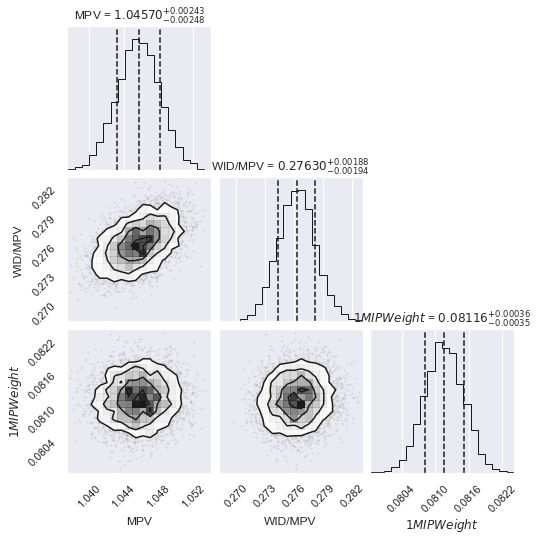

In [17]:
pt_sampler1_T0 = sampler1.chain[0,...].reshape(-1,ndim)
labels_corner = []
labels_corner.append(f"MPV")
labels_corner.append(f"WID/MPV")
for iM in range(numpeaks):
    labels_corner.append(f"${iM+1}MIPWeight$")

figure = corner.corner(pt_sampler1_T0,labels=labels_corner,quantiles=[0.16, 0.5, 0.84],
                       show_titles=True, title_fmt='.5f', title_kwargs={"fontsize": 12})

In [19]:
def plot_MCMC_model(ax,data,trace):
    ax.set_yscale('log')
    plt.errorbar(data[0][8:],data[1][8:],data[2][8:],fmt='.b')
    
    xfit = data[0][8:]
    #yfit = vec_myfuncs_sum(xfit,trace[:,None])
    yfit=np.zeros((trace[:,0][:,None]*xfit).shape)
    for i in range(len(trace[:,0])):
        yfit[i,:]=vec_myfuncs_sum(xfit,trace[i,:])
    
    mu = yfit.mean(0)
    sig = yfit.std(0)
    
    ax.plot(xfit, mu, '--r')
    ax.fill_between(xfit, mu - sig, mu + sig, color='blue',alpha=0.08)
    
    ax.set_xlabel('nMIP')
    ax.set_ylabel('dN/dnMIP')

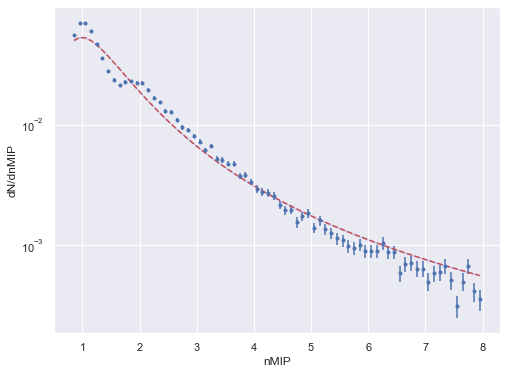

In [20]:
#plot the fit with data 
fig_fitdata= plt.figure(figsize=(8,6))
ax_fitdata = fig_fitdata.add_subplot(1,1,1)
plot_MCMC_model(ax_fitdata,data,pt_sampler1_T0)

Obviously, $N_{max}=1$ is not a good model, the descrpancies between the model and data are big. Without any treatment to the theory or experient error, the error bars asscociated with the fit are underestimated (the error band doesn't cover 2/3 of the data points). Therefore the error bar on the particle count will also be underestimated.

What we are really interested in is the particles count, that is to say we only care about the MIPWeights, let's marginalize over MPV and WID/MPV

In [21]:
pc_tmp=np.zeros(len(pt_sampler1_T0[:,2]))
pc=pc_tmp[:,None]
for i in range(2,ndim):
    pc=pc+pt_sampler1_T0[:,i][:,None]*(i-1)
    
mu=pc.mean(0)
sig=pc.std(0)
print(f"Particles counts = {mu[0]:.7f}" u"\u00B1" f"{sig[0]:.7f}")

Particles counts = 0.0811600±0.0003492


In [22]:
# Array with beta values (1/T)
betas = sampler1.betas
avg_lnl = np.zeros_like(betas) # averages of log likelihood for different beta
var_lnl = np.zeros_like(betas) # variances of log likelihood for different beta
for ib,b in enumerate(betas):
    avg_lnl[ib] = np.mean(sampler1.loglikelihood[ib,...].reshape(-1))
    var_lnl[ib] = np.var(sampler1.loglikelihood[ib,...].reshape(-1))
    
betas0 = np.concatenate((sampler1.betas, np.array([0])))
dbetas = np.diff(betas0)

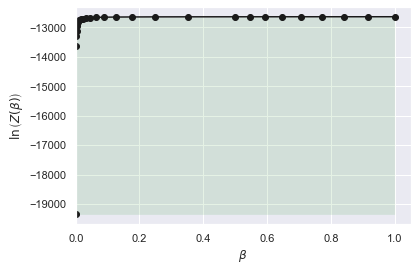

In [23]:
plt.plot(betas,avg_lnl,'ko-')
ax=plt.gca()
ymin=np.ones_like(betas)*min(avg_lnl)
ax.fill_between(betas, ymin,avg_lnl,facecolor='green', alpha=0.1)
fig=plt.gcf()
#ax.set_ylim([-100,-30]);
ax.set_xlim([0.,1.05]);
ax.set_xlabel(r'$\beta$');
ax.set_ylabel(r'$\ln\left(Z(\beta)\right)$');

In [24]:
print("Integrate using trapezoid approximation with N={} points".format(ntemps))
print(f"from {betas0[0]:.4e} to {betas0[-1]:.4e}")
lnzl = -np.trapz(avg_lnl, x=betas)
print(f"\nWe find log-evidence = {lnzl:7.4f}")

Integrate using trapezoid approximation with N=27 points
from 1.0000e+00 to 0.0000e+00

We find log-evidence = -12635.1031


In [25]:
numpeaks = 2
ntemps_lo = 8
ntemps_hi = 21
temps_lo = np.array([2**(i/8.) for i in range(ntemps_lo)])
temps_hi = np.array([np.sqrt(2)**i for i in range(ntemps_hi)])
temps = np.concatenate((temps_lo,temps_hi[temps_hi>max(temps_lo)]))
ntemps=len(temps)

betas=1/temps

# Let us use 10 walkers in the ensemble at each temperature:
ndim = numpeaks+2  # this determines the model dimension
nwalkers = max(10,ndim*2+2)

nburnin=1000
nsteps=5000
nthin = 10 # only record every nthin iteration

nthreads = 1

In [26]:
p0 = (np.random.rand(ntemps,nwalkers, ndim) * \
                    np.tile([1.0,0.3,1.0,1.0], (ntemps, nwalkers, 1))+np.tile([0.5,0.0,0.0,0.0], (ntemps, nwalkers, 1)))

In [27]:
sampler2 = ptemcee.Sampler(nwalkers, ndim, log_likelihood, log_prior, ntemps,
                         threads=nthreads, betas=betas)

In [28]:
print("Running burn-in phase")
for p, lnprob, lnlike in sampler2.sample(p0, iterations=nburnin):
    pass
sampler2.reset()

print("Running MCMC chains")
#Now we sample for nwalkers*niterations, recording every nthin-th sample:

for p, lnprob, lnlike in sampler2.sample(p, iterations=nsteps, thin=nthin):
    pass 

Running burn-in phase
Running MCMC chains


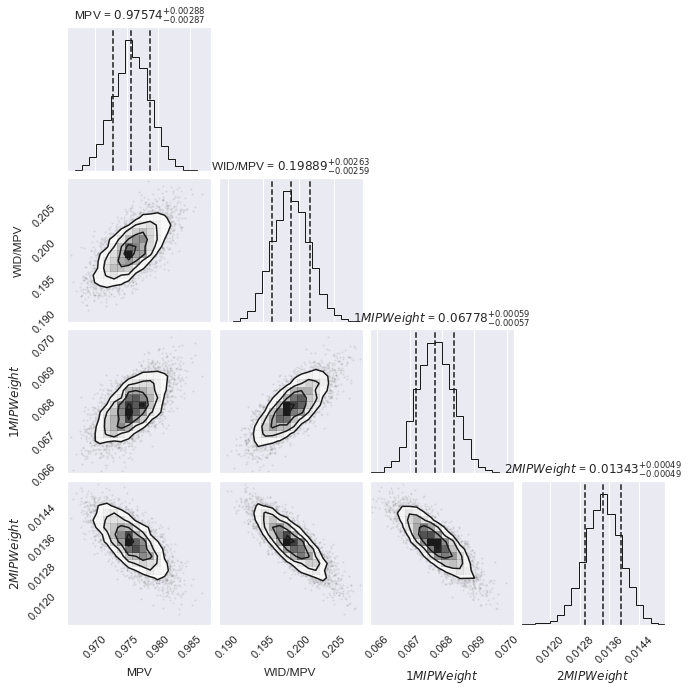

In [29]:
pt_sampler2_T0 = sampler2.chain[0,...].reshape(-1,ndim)
labels_corner = []
labels_corner.append(f"MPV")
labels_corner.append(f"WID/MPV")
for iM in range(numpeaks):
    labels_corner.append(f"${iM+1}MIPWeight$")

figure = corner.corner(pt_sampler2_T0,labels=labels_corner,quantiles=[0.16, 0.5, 0.84],
                       show_titles=True, title_fmt='.5f', title_kwargs={"fontsize": 12})

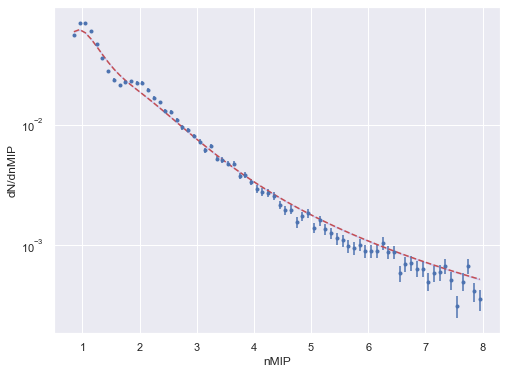

In [30]:
#plot the fit with data 
fig_fitdata= plt.figure(figsize=(8,6))
ax_fitdata = fig_fitdata.add_subplot(1,1,1)
plot_MCMC_model(ax_fitdata,data,pt_sampler2_T0)

In [31]:
pc_tmp=np.zeros(len(pt_sampler2_T0[:,2]))
pc=pc_tmp[:,None]
for i in range(2,ndim):
    pc=pc+pt_sampler2_T0[:,i][:,None]*(i-1)
    
mu=pc.mean(0)
sig=pc.std(0)
print(f"Particles counts = {mu[0]:.7f}" u"\u00B1" f"{sig[0]:.7f}")

Particles counts = 0.0946409±0.0006322


In [32]:
# Array with beta values (1/T)
betas = sampler2.betas
avg_lnl = np.zeros_like(betas) # averages of log likelihood for different beta
var_lnl = np.zeros_like(betas) # variances of log likelihood for different beta
for ib,b in enumerate(betas):
    avg_lnl[ib] = np.mean(sampler2.loglikelihood[ib,...].reshape(-1))
    var_lnl[ib] = np.var(sampler2.loglikelihood[ib,...].reshape(-1))
    
betas0 = np.concatenate((sampler2.betas, np.array([0])))
dbetas = np.diff(betas0)

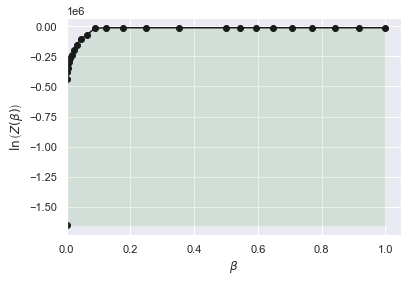

In [35]:
plt.plot(betas,avg_lnl,'ko-')
ax=plt.gca()
ymin=np.ones_like(betas)*min(avg_lnl)
ax.fill_between(betas, ymin,avg_lnl,facecolor='green', alpha=0.1)
fig=plt.gcf()
#ax.set_ylim([-100,-30]);
ax.set_xlim([0.,1.05]);
ax.set_xlabel(r'$\beta$');
ax.set_ylabel(r'$\ln\left(Z(\beta)\right)$');

In [33]:
print("Integrate using trapezoid approximation with N={} points".format(ntemps))
print(f"from {betas0[0]:.4e} to {betas0[-1]:.4e}")
lnzl = -np.trapz(avg_lnl, x=betas)
print(f"\nWe find log-evidence = {lnzl:7.4f}")

Integrate using trapezoid approximation with N=27 points
from 1.0000e+00 to 0.0000e+00

We find log-evidence = -23641.1898


Compare two models:

| N_max | MPV | WID/MPV| 1MIPWeight | 2MIPWeight | particle count | log-evidence |
|---|---|---|---|---|---|---|
|1| 1.04570±0.00245 | 0.27630±0.00191 | 0.08116±0.00035 |  |0.0811600±0.0003492|-12635.1031|
|2| 0.97574±0.00287 | 0.19889±0.00262 | 0.06778±0.00058 | 0.01343±0.00049 |0.0946334±0.0006229|-23641.1898|

Here are the results from Minuit, note the error bars associated with particle count are calculated with the covariance matrix excluding the influence from MPV and WID/MPV

| N_max | MPV | WID/MPV| 1MIPWeight | 2MIPWeight | particle count | \chi^2/ndf |
|---|---|---|---|---|---|---|
|1| 1.008±0.005 | 0.2639±0.0026 | 0.08374±0.00048 |  |0.0837441±0.0003696|26.93|
|2| 0.9863±0.0022 | 0.1553±0.0013 | 0.05994±0.00042 | 0.01866±0.00031 |0.0972642±0.0004803|3.70|

Compare the Bayesian analysis with Minuit (MLE), the values and error bars of particle count are similar. However, Minuit suggests that the model with $N_{max}=2$ is better than the model with $N_{min}=1$ while the Bayesian analysis suggested the opposite. I think the main reason is WID/MPV, although it doesn't influence the particle count and will be marginalized, $N_{max}=2$ model with a smaller WID/MPV can indeed describe the data better. It seems that Minuit found the optimized value for WID/MPV but ptemcee didn't. I thought it is because of the prior, so I make the range of WID/MPV smaller ($0.0\sim0.3$ for this analysis and it was $0.1\sim0.4$) but it didn't. It might also because I didn't use enough steps for the walkers. I am not sure and this issue needs further investigation. 

## 4. Get error bars under control

### 4.1 Method one: Outliers (account for $\sigma_{exp}$)

Used at class so I will only try the second method in this project.

### 4.2 Method two: Add theory error (account for $\sigma_{th}$)

Assume the theory error is the same for all the data points 

In [36]:
def calc_residual_model(data,trace):
    
    yfit=np.zeros((trace[:,0][:,None]*data[0][8:]).shape)
    for i in range(len(trace[:,0])):
        yfit[i,:]=vec_myfuncs_sum(data[0][8:],trace[i,:])
    
    mu = yfit.mean(0)
    res = (data[1][8:]-mu)/data[2][8:]
    return res

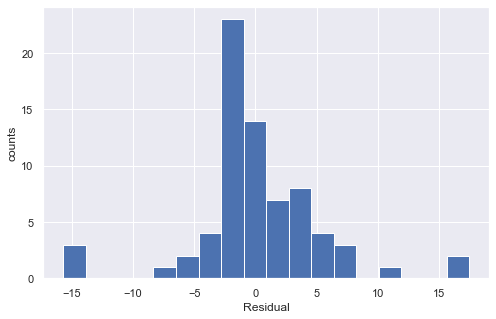

In [54]:
res=calc_residual_model(data,pt_sampler1_T0)
fig, ax = plt.subplots(figsize=(8, 5))
histo = plt.hist(res, bins='auto')
ax.set_xlabel("Residual")
ax.set_ylabel("counts")
plt.show()

In [38]:
from scipy.stats import norm
(mu, sigma_th) = norm.fit(res)
print(sigma_th)

5.277074656169171


In [39]:
def log_likelihood_new(alpha, data=data):
    '''Logarithm of likelihood function.
    
    Returns the negative sum of the squared residuals, which is
    equivalent to a chi-square measure or the logarithm of a
    gaussian likelihood function.
    '''
    x, y, sigma_y = data
    model_y = vec_myfuncs_sum(x,alpha)
    residuals_sq = (model_y - y)**2 / (sigma_y**2+np.tile(sigma_th,(len(sigma_y),1))**2)
    return -0.5 * np.sum(residuals_sq)

In [40]:
def log_posterior_new(alpha, data=data):
    '''Logarithm of posterior.'''
    _alpha = np.asarray(alpha)
    return log_prior(_alpha) + log_likelihood_new(_alpha, data=data)

In [41]:
numpeaks = 1
ntemps_lo = 8
ntemps_hi = 21
temps_lo = np.array([2**(i/8.) for i in range(ntemps_lo)])
temps_hi = np.array([np.sqrt(2)**i for i in range(ntemps_hi)])
temps = np.concatenate((temps_lo,temps_hi[temps_hi>max(temps_lo)]))
ntemps=len(temps)

betas=1/temps

# Let us use 10 walkers in the ensemble at each temperature:
ndim = numpeaks+2  # this determines the model dimension
nwalkers = max(10,ndim*2+2)

nburnin=1000
nsteps=5000
nthin = 10 # only record every nthin iteration

nthreads = 1

In [45]:
p0 = (np.random.rand(ntemps,nwalkers, ndim) * \
                    np.tile([1.0,0.3,1.0], (ntemps, nwalkers, 1))+np.tile([0.5,0.0,0.0], (ntemps, nwalkers, 1)))

In [46]:
sampler1_new = ptemcee.Sampler(nwalkers, ndim, log_likelihood_new, log_prior, ntemps,
                         threads=nthreads, betas=betas)

In [47]:
print("Running burn-in phase")
for p, lnprob, lnlike in sampler1_new.sample(p0, iterations=nburnin):
    pass
sampler1_new.reset()

print("Running MCMC chains")
#Now we sample for nwalkers*niterations, recording every nthin-th sample:

for p, lnprob, lnlike in sampler1_new.sample(p, iterations=nsteps, thin=nthin):
    pass 

Running burn-in phase
Running MCMC chains


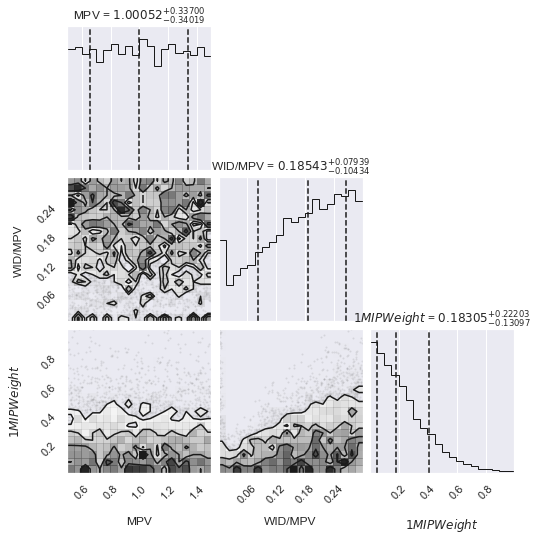

In [48]:
pt_sampler1_T0_new = sampler1_new.chain[0,...].reshape(-1,ndim)
labels_corner = []
labels_corner.append(f"MPV")
labels_corner.append(f"WID/MPV")
for iM in range(numpeaks):
    labels_corner.append(f"${iM+1}MIPWeight$")

figure = corner.corner(pt_sampler1_T0_new,labels=labels_corner,quantiles=[0.16, 0.5, 0.84],
                       show_titles=True, title_fmt='.5f', title_kwargs={"fontsize": 12})

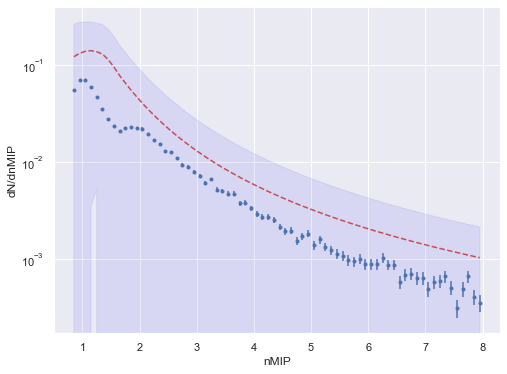

In [49]:
#plot the fit with data 
fig_fitdata= plt.figure(figsize=(8,6))
ax_fitdata = fig_fitdata.add_subplot(1,1,1)
plot_MCMC_model(ax_fitdata,data,pt_sampler1_T0_new)

In [51]:
pc_tmp_new=np.zeros(len(pt_sampler1_T0_new[:,2]))
pc_new=pc_tmp_new[:,None]
for i in range(2,ndim):
    pc_new=pc_new+pt_sampler1_T0_new[:,i][:,None]*(i-1)
    
mu=pc_new.mean(0)
sig=pc_new.std(0)
print(f"Particles counts = {mu[0]:.7f}" u"\u00B1" f"{sig[0]:.7f}")

Particles counts = 0.2252803±0.1814914


$\sigma_{th}=5.2770$ is not a good choice, I need to further tune it. I think a proper $\sigma_{th}$ will give me a $\pm1\sigma$ band (the blue band around the red curve) that covers 2/3 of the data points. Then the value and error bar of the particle count will be more proper. 

## At the end

In this project, I tried to address some problems I encountered in my research with Bayesian analysis. But due to the long computational time, the problems haven't been fully solved yet. But it has been fun playing with it : )